# <a id="0">Table Of Contents</a>
- <a href='#1'>1. Imports</a>
- <a href="#2">2 Read In Data</a>
- <a href="#3">3. Glipmse of Data</a>
- <a href="#4">4. Reducing Memory Size</a>
- <a href="#5">5. Exploratory Data Analysis</a>
    - <a href="#5-1">5.1 Data Description</a>
    - <a href="#5-2">5.2 Examine the Distribution of Target Variable</a>
    - <a href="#5-3" >5.3 Missing Data and Zeroes Visualised</a>
    - <a href="#5-4">5.4 Examining Missing Values</a>
    - <a href="#5-5">5.5 Column Types</a>
    - <a href="#5-6">5.6 Correlations</a>
- <a href="#6">6. Plotting</a>
- <a href="#7">7. Simple Single Series Analysis</a>
- <a href="#8">8. Outlier Distribution</a>
    - <a href="#8-1">8.1 Group Data on Daily Basis</a>
    - <a href="#8-2">8.2 Aggregating Data For Buildings</a>
    - <a href="#8-3">8.3 Identifying Outliers</a>
- <a href="#9">9. Feature Engineering and Modelling</a>
- <a href="#10">10. Pickling Train and Test Data</a>
- <a href="#11">11. Creating Features</a>
- <a href="#12">12. Variables Encoding</a>
- <a href="#13">13. Handling Missing Values</a>

  # <a id="1">1. Imports </a>
  #### <a href="#0">Top</a>

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')
#matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns',150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
 
import os,random, math,psutil, pickle

# <a id="2">2. Read in Data </a>    
###### <a href="#0">Top</a>

In [ ]:
print(os.listdir("../input/ashrae-energy-prediction"))

In [ ]:
%%time
root="../input/ashrae-energy-prediction/"
train_df=pd.read_csv(root+"train.csv")
wtrain_df=pd.read_csv(root+"weather_train.csv")
test_df=pd.read_csv(root+"test.csv")
wtest_df=pd.read_csv(root+"weather_test.csv")
building_df=pd.read_csv(root+"building_metadata.csv")
sample_df=pd.read_csv(root+"sample_submission.csv")

In [ ]:
print(f"Shape of train_df: {train_df.shape}")
print(f"Shape of test_df: {test_df.shape}")

In [ ]:
#changing the datatype of timestamp column of training set
train_df["timestamp"]=pd.to_datetime(train_df["timestamp"], format="%Y-%m-%d %H:%M:%S")

# <a id="3">3 Glimpse of Data</a>  
###### <a href="#0">Top</a>

In [ ]:
print("Size of train_df data is", train_df.shape)
print("Size of wtrain_df data is",wtrain_df.shape)
print("Size of wtest_df data is",wtest_df.shape)
print("Size of test_df data is",test_df.shape )
print("Size of building_df data is", building_df.shape)
print("Size of sample_df data is", sample_df.shape)


# <a id="4"> 4. Reducing Memory Size </a>
###### <a href="#0">Top</a>

In [ ]:
#Calculating Memory utilization in MB's
print("Memory utilization train_df data is", train_df.memory_usage().sum()/1024**2,"MB")
print("Memory utilization of wtrain_train_df data is",wtrain_df.memory_usage().sum()/1024**2,"MB")
print("Memory utilization of wtest_train_df data is",wtest_df.memory_usage().sum()/1024**2,"MB")
print("Memory utilization of test_df data is",test_df.memory_usage().sum()/1024**2,"MB")
print("Memory utilization of building_metadata_df data is",building_df.memory_usage().sum()/1024**2,"MB")
print("Memory utilization of sample_submission_df data is",sample_df.memory_usage().sum()/1024**2,"MB")

In [ ]:
# Function to reduce the dataframe size

def reduce_mem(df, verbose=True):
    numerics=['int16','int32','int64','float16','float32','float64']
    start_mem=df.memory_usage().sum()/1024**2
    for col in df.columns:
        col_type=df[col].dtypes
        if col_type in numerics:
            c_min=df[col].min()
            c_max=df[col].max()
            if str(col_type)[:3]=="int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col]=df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col]=df[col].astype(np.int16)
                elif c_min >np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col]=df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col]=df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col]=df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col]=df[col].astype(np.float32)
                elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
                    df[col]=df[col].astype(np.float64)
    end_mem=df.memory_usage().sum()/1024**2
    if verbose: print("Memory usage decreased to {:5.2f} MB ({:.1f}% reduction)".format(end_mem,100*(start_mem-end_mem)/start_mem))
    return df

In [ ]:
train_df=reduce_mem(train_df)
wtrain_df=reduce_mem(wtrain_df)
wtest_df=reduce_mem(wtest_df)
test_df=reduce_mem(test_df)
building_df=reduce_mem(building_df)
sample_df=reduce_mem(sample_df)

# <a id="5">5. Exploratory Data Analysis</a>
###### <a href="#0">Top</a>

## <a id="5-1">5.1 Data Description</a>
###### <a href="#0">Top</a>

In [ ]:
#Column Name of Dataframes
def colname(df):
    name=df.columns
    return name

In [ ]:
train_df.head(3)

In [ ]:
train_df.columns.values

In [ ]:
wtrain_df.head(3)

In [ ]:
wtrain_df.columns.values

In [ ]:
wtest_df.head(3)

In [ ]:
wtest_df.columns.values

In [ ]:
building_df.head(3)

In [ ]:
building_df.columns.values

## <a id="5-2">5.2 Examine the Distribution of Target Variable</a>
##### <a href="#0">Top</a>

In [ ]:
# target is meter_reading
#individual subplots for {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}
grouped=train_df.groupby(['meter'])["meter_reading"]
ncols=2
nrows=int(np.ceil(grouped.ngroups/ncols))
fig,axes=plt.subplots(nrows=nrows,ncols=ncols,figsize=(30,15))
for (key,ax) in zip(grouped.groups.keys(),axes.flatten()):
    if key==0:
        label="Electricity"
    elif key==1:
        label="Chilled Water"
    elif key==2:
        label="Steam"
    elif key==3:
        label="Hot Water"
    grouped.get_group(key).plot(ax=ax, label=label)
    ax.legend(loc="upper left")
    ax.set_xlabel("Meter Reading")
    ax.set_ylabel("Frequency")
plt.show();
    

In [ ]:
#checking distribution of meterreading as a whole
plt.figure(figsize=(15,8))
plt.plot(train_df["meter_reading"])
plt.title("Distribution of Meter Reading as Whole")
plt.xlabel("Meter Reading")
plt.ylabel("Frequency");

In [ ]:
train_df["meter_reading"].plot(kind="hist",
                              bins=30,
                              figsize=(30,8),
                              title="Distribution of Target Variable (meter_reading)")
plt.show()

## <a id="5-3">5.3 Missing Data and Zeroes Visualised</a>
###### <a href="#0">Top</a>


In [ ]:
 #Goal: for each building and each meter type,visualise where target is missing and where target is zero vs time
#Load Data
train=train_df.set_index(["timestamp"])
#Plot missing values per building per meter type

f,a=plt.subplots(1,4,figsize=(20,30))
for meter in np.arange(4):
    df=train[train.meter==meter].copy().reset_index()
    df['timestamp']=pd.to_timedelta(df.timestamp).dt.total_seconds()/3600
    df.timestamp=df.timestamp.astype(int)
    #print(df.timestamp.min())
    df.timestamp-=df.timestamp.min()
    #print(df.timestamp.max())
    missmap=np.empty((1449,df.timestamp.max()+1))
    #print(missmap.shape)
    missmap.fill(np.nan)
    for l in df.values:
        if l[2]!=meter:continue
        missmap[int(l[1]),int(l[0])]=0 if l[3]==0 else 1
    a[meter].set_title(f'meter{meter}')
    sns.heatmap(missmap,cmap='Paired',ax=a[meter],cbar=False)

## <a id="5-4">5.4 Examining Missing Values</a>
##### <a href="#0">Top</a>

In [ ]:
#checking missing values for train_df
total=train_df.isnull().sum().sort_values(ascending=False)
percent=(train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
missing_train=pd.concat([total,percent], axis=1, keys=["Total","Percentage"])
missing_train.head()

In [ ]:
#checking missing values for wtrain_df
total=wtrain_df.isnull().sum().sort_values(ascending=False)
percent=(wtrain_df.isnull().sum()/wtrain_df.isnull().count()*100).sort_values(ascending=False)
missing_wtrain=pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_wtrain

In [ ]:
#checking missing values for wtest_df
total=wtest_df.isnull().sum().sort_values(ascending=False)
percent=(wtest_df.isnull().sum()/wtest_df.isnull().count()*100).sort_values(ascending=False)
missing_wtest=pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_wtest

In [ ]:
#checking missing values in building_df
total=building_df.isnull().sum().sort_values(ascending=False)
percent=(building_df.isnull().sum()/building_df.isnull().count()*100).sort_values(ascending=False)
missing_building=pd.concat([total,percent],axis=1,keys=["Total","Percent"])
missing_building

## <a id="5-5">5.5 Column Types</a>
#### <a href="#0">Top</a>

In [ ]:
#Columns in train_df
print(f'Column types in train_df::\n{train_df.dtypes.value_counts()}')

#Column in wtrain_df
print(f'\nColumn types in wtrain_df::\n{wtrain_df.dtypes.value_counts()}')

#Column in wtest_df
print(f'\nColumn types in wtest_df::\n{wtest_df.dtypes.value_counts()}')

#Column in wtrain_df and building_df
print(f'\nColumn types in building_df::\n{building_df.dtypes.value_counts()}')

In [ ]:
#Number of unique classes in each categorical/object column in train_df
print(f'No. of unique classes in column of object type in train_df:\n{train_df.select_dtypes("object").apply(pd.Series.nunique,axis=0)}')

#Number of unique classes in each categorical/object column in wtrain_df
print(f'\nNo. of unique classes in column of object type in wtrain_df:\n{wtrain_df.select_dtypes("object").apply(pd.Series.nunique,axis=0)}')

#Number of unique classes in each categorical/object column in wtest_df
print(f'\nNo. of unique classes in column of object type in wtest_df:\n{wtest_df.select_dtypes("object").apply(pd.Series.nunique,axis=0)}')

#Number of unique classes in each categorical/object column in building_df
print(f'\nNo. of unique classes in column of object type in building_df:\n{building_df.select_dtypes("object").apply(pd.Series.nunique,axis=0)}')

## <a id="5-6">5.6 Correlations</a>
#### <a href="#0">Top</a>

In [ ]:
#finding the correleations in train_df

cor=train_df.corr()
print(cor)

In [ ]:
#Plotting the coorelations in seaborn

plt.figure(figsize=(20,8))
sns.heatmap(cor, annot=True,cmap='RdYlBu', vmax=0.6)
plt.title("Correlation Heatmap");

# <a id="6">6. Plotting</a>
#### <a href="#0">Top</a>

In [ ]:
#Finding unique buildings in train_df
print(f'No of unique buildings in the data:{train_df.building_id.nunique()}')

In [ ]:
#Plotting the distribution of meter_reading using hisogram
train_df.meter_reading.hist(figsize=(7,5))
plt.xlabel("Meter Reading")
plt.ylabel("Frequency")
plt.title("Histogram Meter Reading");

In [ ]:
#Plotting on wtrain_df and wtest_df
#wtrain_df.head()
#Plotting air_temperature distribution of wtrain_df and wtest_df

def plot_dist(col, kde=True):
    ''' plot dist curve on wtrain_df ad wtest_df for a given column name'''
    
    fig,ax=plt.subplots(figsize=(20,5))
    sns.distplot(wtrain_df[col].dropna(), color="green", ax=ax).set_title(f'Distribution of {col}',fontsize=16)
    sns.distplot(wtest_df[col].dropna(),ax=ax,color="purple").set_title(f'Distribution of {col}',fontsize=16)
    plt.xlabel(col, fontsize=16)
    plt.legend(['train','test'])
    plt.show()

In [ ]:
name=list(colname(wtrain_df))
#print(name)
#Plottting distribution of air_temperature
plot_dist("air_temperature")

In [ ]:
#Plotting Disribution of cloud_coverage
plot_dist("cloud_coverage")

In [ ]:
#Plotting dew_temperature
plot_dist('dew_temperature')

In [ ]:
#Plotting sea_level_pressure
plot_dist('sea_level_pressure')

In [ ]:
#Plotting distribution of wind_direction
plot_dist('wind_direction')

# <a id="7">7. Simple Single Series Analysis</a>
#### <a href="#0">Top</a>

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Check the stationarity of the timeseries

def check_stn(ts):
    #Determining rolling statistics
    rolmean=ts.rolling(window=12, center=False).mean()
    rolstd=ts.rolling(window=12,center=False).std()
    
    #Plot rolling statistics
    plt.figure(figsize=(20,8))
    orig=plt.plot(ts, label="Original")
    mean=plt.plot(rolmean, label="Rolling Mean")
    std=plt.plot(rolstd,label="Rolling Std")
    plt.xlabel("timestamp")
    plt.ylabel("meter_reading")
    plt.legend(loc="best")
    plt.title("Plotting Rolling Mean and Rolling Std")
    plt.show()
    
    #Perform Dickey-Fuller Test
    print("Result of Dickey-Fuller Test")
    ts=ts.iloc[:,0].values
    dftest=adfuller(ts, autolag="AIC")
    dfoutput=pd.Series(dftest[0:4],index=["Test Statistics","p-value","No.Of Lags Used","No. Of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value of {key}']=value
    print(dfoutput)
    

In [ ]:
ts=pd.DataFrame(train_df.groupby(['timestamp']).meter_reading.sum())
check_stn(ts)
#Note: For TimeSeries to be Stationary value of Test Statistics has to be less then the Critical Value.
#Conclusion: This is a stationary time series

In [ ]:
#Decomposition of TimeSeries
import statsmodels.api as sm
#multiplicative 
res=sm.tsa.seasonal_decompose(ts.values,period=12, model="multiplicative")
fig=res.plot()

In [ ]:
#Additive
res=sm.tsa.seasonal_decompose(ts.values,period=12, model="additive")
fig=res.plot()

# <a id="8">8. Outlier Distribution</a>
#### <a href="#0">Top</a>

In [ ]:
y_mean=train_df.groupby(['timestamp'])["meter_reading"].mean()
plt.figure(figsize=(10,5))
plt.plot(y_mean)
plt.xlabel("timestamp")
plt.ylabel("Mean Of meter_reading")
plt.title("Plotting Mean of meter_reading and timestamp")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_mean.rolling(window=10).std())
ax=plt.axhline(y=0.009,color="red")
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_mean.rolling(window=10).std())
plt.axhline(y=0.009,color="red")
plt.axhspan(0, 905, color='green', alpha=0.1)
plt.axhspan(906,1505, color='red', alpha=0.1);

## <a id="8-1">8.1 Group Data on Daily Basis</a>
#### <a href="#0">Top</a>

In [ ]:
train_df["meter"]=pd.Categorical(train_df.meter).rename_categories({0:"Electricity",1:"Chilled_Water",2:"Steam",3:"Hot_Water"})
daily_train=train_df.copy()
daily_train['date']=daily_train.timestamp.dt.date
daily_train=daily_train.groupby(["date","building_id","meter"]).sum()
daily_train.head(2)

## <a id="8-2">8.2 Aggregating Data For Buildings</a>
#### <a href="#0">Top</a>

In [ ]:
daily_train_agg=daily_train.groupby(["date","meter"]).agg(["sum","mean","idxmax","max"])
daily_train_agg=daily_train_agg.reset_index()
level_0=daily_train_agg.columns.droplevel(0)
level_1=daily_train_agg.columns.droplevel(1)
level_0=['' if x=='' else '_'+ x for x in level_0]
daily_train_agg.columns=level_1 + level_0
daily_train_agg.rename_axis(None,axis=1)
daily_train_agg.head(3)

In [ ]:
plt.figure(figsize=(20,8))
ax=sns.lineplot(x="date",y="meter_reading_sum", data=daily_train_agg, hue="meter")
ax.set_title("Total Energy per day")
ax.set_xlabel("Date")
plt.show()

In [ ]:
plt.figure(figsize=(20,8))
ax=sns.lineplot(x="date",y="meter_reading_max", data=daily_train_agg, hue="meter")
ax.set_title("Maximum Energy per day")
ax.set_xlabel("Date")
plt.show()

## <a id="8-3">8.3 Identifying Outliers</a>
#### <a href="#0">Top</a>

In [ ]:
daily_train_agg["building_id_max"]=[x[1] for x in daily_train_agg['meter_reading_idxmax'] ]
daily_train_agg.head()

In [ ]:
# No of days a building has the maximum electricity consumption

out_elec=daily_train_agg[daily_train_agg["meter"]=="Electricity"]["building_id_max"].value_counts()
print(f'Number of time buildings having maximum consumption of Electricity:\n{out_elec}')

In [ ]:
# Maximum electricity is consumed by only 6 buildings
plt.figure(figsize=(20,8))
daily_train_elec=daily_train_agg[daily_train_agg['meter']=="Electricity"]
#print(f'Data type of building_id_max is :: {daily_train_elec.building_id_max.dtype}') #Note: It has to be categorical
daily_train_elec["building_id_max"]=pd.Categorical(daily_train_elec["building_id_max"])

ax=sns.scatterplot(x="date",y="meter_reading_max",hue="building_id_max", data=daily_train_elec,alpha=0.8)
ax.set_xlim((daily_train_elec["date"].min()+pd.to_timedelta(-1,unit="M"),daily_train_elec["date"].max()+pd.to_timedelta(2,unit="M")))
plt.xlabel("Date", fontsize=16)
plt.ylabel("meter_reading_max",fontsize=16)
plt.title("Building Having High Consumption of Electricity", fontsize=16)
plt.show()

In [ ]:
#Number of days the buidling having higher consumption for ChilledWater
daily_train_chilled=daily_train_agg[daily_train_agg["meter"]=="Chilled_Water"]
daily_train_chilled["building_id_max"]=pd.Categorical(daily_train_chilled["building_id_max"])
bld_count=daily_train_chilled["building_id_max"].value_counts()
print(f'No of days building has high demand for Chilled_Water:\n{bld_count}')

In [ ]:
#Plotting the buildings meter_reading for building having demand of Chilled_Water
plt.figure(figsize=(20,8))
ax=sns.scatterplot(x="date",y="meter_reading_max",hue="building_id_max", data=daily_train_chilled)
plt.xlim((daily_train_chilled["date"].min()+pd.to_timedelta(-2,unit="M"), daily_train_chilled["date"].max()+pd.to_timedelta(2,unit="M")))
plt.xlabel("Date",fontsize=16)
plt.ylabel("meter_reading",fontsize=16)
plt.show()

In [ ]:
#No of days building having high demand for Steam
daily_train_steam=daily_train_agg[daily_train_agg["meter"]=="Steam"]
daily_train_steam["building_id_max"]=pd.Categorical(daily_train_steam["building_id_max"])
steam_count=daily_train_steam["building_id_max"].value_counts()
print(f'Number of days building having high demands for Steam among all buildings:\n{steam_count}')

In [ ]:
#Plotting the meter_reading for buildings having high demand for Steam for each date.
plt.figure(figsize=(20,8))
ax=sns.scatterplot(x="date",y="meter_reading_max", data=daily_train_steam, hue="building_id_max")
plt.xlim((daily_train_steam["date"].min()+pd.to_timedelta(-2,unit="M"),daily_train_steam["date"].max()+pd.to_timedelta(2,unit="M")))
plt.xlabel("Date", fontsize=16)
plt.ylabel("meter_reading_max",fontsize=16)
plt.show()

In [ ]:
#No of days each building have high demand for Hot_Water

daily_train_hw=daily_train_agg[daily_train_agg["meter"]=='Hot_Water']
daily_train_hw["building_id_max"]=pd.Categorical(daily_train_hw["building_id_max"])
hw_count=daily_train_hw["building_id_max"].value_counts()
print(f'No of days each building has high demand for Hot_Water:\n{hw_count}')

In [ ]:
#Plotting meter_reading for each building datewise having high demand for Hot_Water
plt.figure(figsize=(20,8))
ax=sns.scatterplot(x="date",y='meter_reading_max',data=daily_train_hw,hue="building_id_max")
plt.xlabel("Date", fontsize=16)
plt.ylabel("meter_reading_max",fontsize=16)
plt.title("Plotting meter_reading_max of each builiding having high demand for Hot_water")
plt.xlim((daily_train_hw["date"].min()+pd.to_timedelta(-2,unit="M"),daily_train_hw["date"].max()+pd.to_timedelta(2,unit="M")))
plt.show()

# <a id="9">9. Feature Engineering and Modelling</a>
#### <a href="#0">Top</a>

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import train_test_split

## <a id="9-1">9.1 Merging buidling_df and train_df</a>
#### <a href="#0">Top</a>

In [ ]:
wtrain_df["timestamp"]=pd.to_datetime(wtrain_df["timestamp"])
wtest_df["timestamp"]=pd.to_datetime(wtest_df["timestamp"])
train_df["timestamp"]=pd.to_datetime(train_df["timestamp"])
test_df["timestamp"]=pd.to_datetime(test_df["timestamp"])

In [ ]:
temp_df=train_df[["building_id"]] ##Note this syntax creates dataframe from a single column of DataFrame instead of Series
temp_df=temp_df.merge(building_df,how="left",on="building_id")
del temp_df["building_id"]
train_df=pd.concat([train_df,temp_df],axis=1)
train_df.columns

In [ ]:
temp_df=train_df[['building_id']]
temp_df=temp_df.merge(building_df,on=["building_id"],how="left")
del temp_df["building_id"]
test_df=pd.concat([test_df,temp_df],axis=1)
test_df.columns

## <a id="9-2">9.2 Merging wtrain_df and train_df</a>
#### <a href="#0">Top</a>

In [ ]:
# Merging wtest_df to test_df
temp_df=train_df[["site_id","timestamp"]]
temp_df=temp_df.merge(wtrain_df,on=["site_id","timestamp"],how="left")
del temp_df["site_id"], temp_df["timestamp"]
train_df=pd.concat([train_df,temp_df],axis=1)
train_df.columns

In [ ]:
# Merging wtest_df to test_df
temp_df=test_df[["site_id","timestamp"]]
temp_df=temp_df.merge(wtest_df,on=["site_id","timestamp"],how="left")
del temp_df["site_id"], temp_df["timestamp"]
test_df=pd.concat([test_df,temp_df],axis=1)
test_df.columns

# <a id="10">10. Pickling Of Train and Test Data</a>
#### <a href="#0">Top</a>

In [ ]:
#Saving the train_df and test_df as their pickle file
train_df.to_pickle("train_df.pickle")
test_df.to_pickle("test_df.pickle")

In [ ]:
import gc
del train_df, test_df
gc.collect()

In [ ]:
#reading train and test data from pickle file
train_df=pd.read_pickle("train_df.pickle")
test_df=pd.read_pickle("test_df.pickle")

# <a id="11">11. Features</a>
#### <a href="#0">Top</a>

In [ ]:
print(train_df.columns)

In [ ]:
train_df["age"]=train_df["year_built"].max() - train_df["year_built"] + 1
test_df["age"]=test_df["year_built"].max() - test_df["year_built"] + 1

In [ ]:
train_df["month_datetime"]=train_df["timestamp"].dt.month.astype(np.int8)
train_df["weekofyear_datetime"]=train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df["dayofyear_datetime"]=train_df['timestamp'].dt.dayofyear.astype(np.int8)
train_df["hour_datetime"]=train_df['timestamp'].dt.hour.astype(np.int8)
train_df["day_week"]=train_df["timestamp"].dt.dayofweek.astype(np.int8)
train_df["day_month"]=train_df["timestamp"].dt.day.astype(np.int8)
train_df["week_of_month"]=train_df["timestamp"].dt.day/7
train_df['week_of_month']=train_df["week_of_month"].apply(lambda x: math.ceil(x)).astype(np.int8)

train_df['year_built']=train_df["year_built"] - 1900
train_df["square_feet"]=np.log(train_df['square_feet'])

In [ ]:
test_df["month_datetime"]=test_df["timestamp"].dt.month.astype(np.int8)
test_df["weekofyeat_datetime"]=test_df["timestamp"].dt.weekofyear.astype(np.int8)
test_df['dayofyear_dattetime']=test_df["timestamp"].dt.dayofyear.astype(np.int8)
test_df["hour_datetime"]=test_df["timestamp"].dt.hour.astype(np.int8)
test_df["day_week"]=test_df["timestamp"].dt.dayofweek.astype(np.int8)
test_df['day_month']=test_df['timestamp'].dt.day.astype(np.int8)
test_df["week_of_month"]=test_df["timestamp"].dt.day/7
test_df["week_of_month"]=test_df["week_of_month"].apply(lambda x: math.ceil(x)).astype(np.int8)

test_df['year_built']=test_df["year_built"]-1900
test_df["square_feet"]=np.log(test_df['square_feet'])

# <a id="12">12. Variables Encoding</a>
#### <a href="#0">Top</a>

### 16-Wind Compass Rose
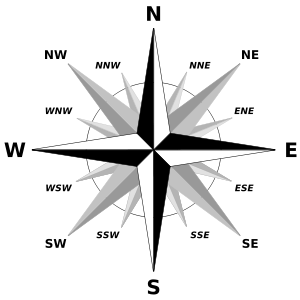

In [ ]:
#Converting wind_direction into 16-wind compass rose from degrees
def degtocomp(colval):
    val=int(colval/22.5)
    arr=[i for i in range(0,16)]
    a=arr[(val%16)]
    return a

In [ ]:
#train_df["wind_direction"]=train_df["wind_direction"].apply(degtocomp)

In [ ]:
le=LabelEncoder()
train_df["primary_use"]=le.fit_transform(train_df["primary_use"]).astype('int8')
test_df["primary_use"]=le.fit_transform(test_df["primary_use"]).astype('int8')

In [ ]:
print(f'Number of unique values in primary_use for train_df:\n {pd.unique(train_df["primary_use"]).ravel()}\n')
print(f'Number of unique values in primary_use for test_df:\n {pd.unique(test_df["primary_use"]).ravel()}')

### Note: Feature Selection
- Find the optimal feature subset using an evaluation measure. The choice of evaluation metric distinguish the three main strategies of feature selection   algorithms: the wrapper strategy, the filter strategy, and the embedded strategy.
- Filter methods:
    - information gain
    - chi-square test
    - correlation coefficient
    - variance threshold
- Wrapper methods:
    - recursive feature elimination
    - sequential feature selection algorithms
- Embedded methods:
    - L1 (LASSO) regularization
    - decision tree

In [ ]:
#Method to impute missing values
def avg_imputation(df, colname):
    imputation=train_df.groupby(['timestamp'])[colname].mean()
    df.loc[df[colname].isnull(),colname]=df[df[colname].isnull()][[colname]].apply(lambda x: imputation[df['timestamp'][x.index]].values)
    del imputation
    return df

In [ ]:
train_df=avg_imputation(train_df,"wind_direction")
train_df=avg_imputation(train_df,"wind_speed")

# <a id="13">13. Handling Missing Values</a>
#### <a href="#0">Top</a>

In [ ]:
#Missing values in train data
count=train_df.isnull().sum().sort_values(ascending=False)
perc=(train_df.isnull().sum()/train_df.isnull().count()*100).sort_values(ascending=False)
mising=pd.concat([count,perc], axis=1, keys=["Mis_Count","Mis_Percentage"])
mising=mising[mising["Mis_Count"]>0]
print(mising)

In [ ]:
#Missing valuesin test data
count=test_df.isnull().sum().sort_values(ascending=False)
perc=(test_df.isnull().sum()/test_df.isnull().count()*100).sort_values(ascending=False)
mising=pd.concat([count,perc], axis=1, keys=["Test_Mis_Count","Test_Mis_Percentage"])
mising=mising[mising["Test_Mis_Count"]>0]
print(mising)

In [ ]:
train_df["floor_count"]=train_df["floor_count"].fillna(-999).astype(np,int16)
test_df["floor_count"]=test_df["floor_count"].fillna(-999).astype(np,int16)

train_df["year_built"]=train_df["year_built"].fillna(-999).astype(np.int16)
test_df["year_built"]=test_df["year_built"].fillna(-999).astype(np.int16)

train_df["age"]=train_df["age"].fillna(-999).astype(np.int16)
test_df["age"]=test_df["age"].fillna(-999).astype(np.int16)

train_df["cloud_coverage"]=train_df["cloud_coverage"].fillna(-999).astype(np.int16)
test_df["cloud_coverage"]=test_df["cloud_coverage"].fillna(-999).astype(np.int16)